# Demo 1: Discover post-training quantization in TensorFlow

Post-training quantization is like shrinking your suitcase for a trip without removing any essential items—you're making your model more compact and efficient without compromising its core capabilities.

> **Overview**: We'll apply post-training quantization to optimize a pre-trained image classification model, converting it to LiteRT format and measuring improvements in size, speed, and efficiency.
> 
> **Goal**: Transform a full-precision model into a smaller, faster version that runs efficiently on resource-constrained devices without retraining.
> 
> **Scenario**: Imagine you work for a wildlife conservation organization deploying smart camera traps in remote areas. These battery-powered cameras need to identify different animal species locally to prioritize important footage for transmission back to base via limited satellite connectivity.
> 
> Your team has a pre-trained MobileNetV2 model that accurately identifies local species, but:
> <br> - _Battery life is too short with the current model_
> <br> - _Limited CPU power causes high latency_
> <br> - _Storage limitations prevent storing all footage_
> 
> You have selected post-training quantization as the <ins>quickest-to-implement model compression technique</ins> that can ensure your model runs efficiently on these edge devices.
> 
> **Tools**: TensorFlow, TensorFlow Lite Runtime (LiteRT), MobileNetV2, Matplotlib

## Step 1: Setup
Let's begin by importing the necessary libraries and setting up our environment:

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install tensorflow tflite_runtime

In [14]:
# Reduce logging verbosity (TensorFlow has a few!)
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

# Import libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tflite_runtime.interpreter as tflite
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

# Set up plotting
plt.style.use('ggplot')

# Check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    
    # Set tensorflow to run on CPU
    tf.config.set_visible_devices([], 'GPU')
    
    print("Skipping GPU - Set tensorflow to run on CPU .")
else:
    print("No GPU found. Running on CPU.")

    
# Create output directory
output_dir = "assets/demo1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Setup complete!")

No GPU found. Running on CPU.
Setup complete!


> **Environment matters**: While quantization works on any hardware, you'll see the most dramatic speed improvements on devices with dedicated hardware acceleration for integer operations (like many mobile CPUs and edge TPUs). If you're running on a desktop GPU, the speed benefits may be less pronounced as GPUs are already optimized for parallel floating-point operations.

## Step 2: Create helper functions for visualization and evaluation

Now we'll create functions to help us measure and visualize the impact of our quantization techniques. These functions will reveal exactly how much size reduction and speed improvement we're achieving, making it easy to compare different optimization approaches.

In [3]:
def plot_model_size_comparison(model_sizes, labels):
    """Visualize model size differences between original and quantized models"""
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, model_sizes, color=['#3498db', '#2ecc71', '#e74c3c'])
    
    # Add size labels and percentage reduction
    for i, bar in enumerate(bars):
        if i > 0:  # For quantized models
            reduction = (1 - model_sizes[i]/model_sizes[0]) * 100
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f"{model_sizes[i]:.1f} MB\n(-{reduction:.1f}%)", 
                     ha='center', va='bottom', fontweight='bold')
        else:  # Original model
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f"{model_sizes[i]:.1f} MB", 
                     ha='center', va='bottom', fontweight='bold')
    
    plt.title('Model Size Comparison', fontsize=14)
    plt.ylabel('Size (MB)', fontsize=12)
    plt.ylim(0, max(model_sizes) * 1.2)  # Add some space for labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=11)
    plt.show()

def measure_inference_time(model_function, input_data, num_runs=10):
    """Measure average inference time over multiple runs"""
    # Warmup run
    model_function(input_data)
    
    # Timed runs
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        model_function(input_data)
        end_time = time.time()
        times.append((end_time - start_time) * 1000)  # Convert to ms
    
    return {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times)
    }

def plot_inference_comparison(inference_times, labels):
    """Visualize inference time differences between original and quantized models"""
    means = [t['mean'] for t in inference_times]
    stds = [t['std'] for t in inference_times]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, means, yerr=stds, capsize=10, color=['#3498db', '#2ecc71', '#e74c3c'])
    
    # Add time labels and speedup percentage
    for i, bar in enumerate(bars):
        if i > 0:  # For quantized models
            speedup = (1 - means[i]/means[0]) * 100
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                     f"{means[i]:.1f} ms\n({speedup:.1f}% faster)", 
                     ha='center', va='bottom', fontweight='bold')
        else:  # Original model
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                     f"{means[i]:.1f} ms", 
                     ha='center', va='bottom', fontweight='bold')
    
    plt.title('Inference Time Comparison', fontsize=14)
    plt.ylabel('Time (ms)', fontsize=12)
    plt.ylim(0, max(means) * 1.3)  # Add space for error bars and labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def get_model_size(file_path):
    """Get the size of a model file in MB"""
    return os.path.getsize(file_path) / (1024 * 1024)

## Step 3: Load the pre-trained MobileNetV2 model

Now we'll load our pre-trained MobileNetV2 model. This is a powerful image classification model but may be too resource-intensive for edge devices. We need to understand its size and structure before we begin our optimization process.

**Note**: We should first establish baseline performance metrics using a test dataset that matches our target environment. For brevity, we're skipping the baseline benchmarking in this demo.

In [4]:
print("📱 Loading pre-trained MobileNetV2 model...")

# Load pre-trained MobileNetV2 model with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=True)
print(f"Model loaded with {base_model.count_params():,} parameters")

# Save the original Keras model for size comparison
original_model_path = f"{output_dir}/wildlife_classifier_original.keras"
base_model.save(original_model_path)
original_size = get_model_size(original_model_path)
print(f"Original model size: {original_size:.2f} MB")

📱 Loading pre-trained MobileNetV2 model...
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded with 3,538,984 parameters
Original model size: 14.05 MB


> **Know your model's composition**: Understanding your model's architecture is crucial before quantization. MobileNetV2 is already designed for efficiency, using depthwise separable convolutions, but its 3.5M parameters still consume significant memory as 32-bit floats (4 bytes per parameter). This represents about 14MB of storage, which we'll soon reduce dramatically while preserving functionality.

## Step 4: Convert the baseline model to lite format

Before we can apply quantization, we need to convert our model to TensorFlow Lite format. TFLite is TensorFlow's specialized format for mobile and edge devices, designed to be smaller and faster than standard TensorFlow models, even before quantization is applied.

In [5]:
print("🔄 Converting baseline model to lite format...")

# Create LiteRT converter
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)

# Convert to LiteRT model (without quantization yet)
lite_model = converter.convert()

# Save the regular .tflite model
lite_model_path = f"{output_dir}/wildlife_classifier.lite"
with open(lite_model_path, 'wb') as f:
    f.write(lite_model)

regular_lite_size = get_model_size(lite_model_path)
print(f"Regular LiteRT model size: {regular_lite_size:.2f} MB")

🔄 Converting baseline model to lite format...
INFO:tensorflow:Assets written to: /tmp/tmpagxzpizj/assets


INFO:tensorflow:Assets written to: /tmp/tmpagxzpizj/assets


Saved artifact at '/tmp/tmpagxzpizj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  136218447438320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447443424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447439728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447445360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380508976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380504928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13621844743

W0000 00:00:1746174966.761194      98 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746174966.761239      98 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1746174966.921789      98 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Regular LiteRT model size: 13.34 MB


> **TFLite → LiteRT transition**: TensorFlow Lite (TFLite) is transitioning to TensorFlow's Lightweight Runtime (LiteRT). This is more than a name change—it represents a unification of TensorFlow's runtime architectures. The API is mostly backward compatible, but newer features like delegate APIs and model optimization tools are now being developed exclusively for LiteRT. For new projects, start with LiteRT; for existing TFLite deployments, plan a migration path.

## Step 5: Apply post-training quantization

Now comes the key step—quantization. We're taking our high-precision model and reducing the numerical precision to make it smaller and faster. This is possible because neural networks can often maintain accuracy with much lower precision than they were trained with.
We'll explore two different quantization techniques, each with different tradeoffs between simplicity, performance, and accuracy.

### A. Dynamic range quantization

First, let's apply dynamic range quantization - the simplest form of quantization that converts weights to 8-bit integers but keeps activations in floating-point. This approach is easy to implement and gives significant size reduction with minimal accuracy impact.

In [6]:
print("🔍 Applying dynamic range quantization...")

# Create a new converter for dynamic quantization
dynamic_converter = tf.lite.TFLiteConverter.from_keras_model(base_model)

# Set the optimization flag to optimize for size and specify the output type
dynamic_converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynamic_converter.inference_output_type = tf.float32

# Convert with dynamic range quantization
dynamic_tflite_model = dynamic_converter.convert()

# Save the dynamically quantized model
dynamic_model_path = f"{output_dir}/wildlife_classifier_dynamic_quantized.tflite"
with open(dynamic_model_path, 'wb') as f:
    f.write(dynamic_tflite_model)

dynamic_size = get_model_size(dynamic_model_path)
print(f"Dynamic quantized model size: {dynamic_size:.2f} MB")
print(f"Size reduction: {(1 - dynamic_size/original_size) * 100:.1f}%")

🔍 Applying dynamic range quantization...
INFO:tensorflow:Assets written to: /tmp/tmpuppubcqa/assets


INFO:tensorflow:Assets written to: /tmp/tmpuppubcqa/assets


Saved artifact at '/tmp/tmpuppubcqa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  136218447438320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447443424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447439728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447445360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380508976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380504928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13621844743

Dynamic quantized model size: 3.62 MB
Size reduction: 74.2%


W0000 00:00:1746174976.185296      98 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746174976.185331      98 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


> **How dynamic quantization works**: This method converts weights to 8-bit integers at load time, but keeps activations in floating-point during computation. Under the hood, it determines the minimum and maximum values in each weight tensor, then maps that range to 8-bit integers (0-255). During inference, it dequantizes these values back to floating point for operations. This technique works exceptionally well for NLP models (LSTMs, Transformers), where weights consume most of the memory but activations are relatively sparse.

### B. Static integer quantization

Now let's go even further with full integer quantization. This technique quantizes both weights AND activations to integers, which can provide even better performance on devices with specialized integer hardware. However, it requires a bit more work - we need sample data to calibrate the quantization parameters.

In [7]:
print("Creating sample data for quantization calibration...")

# Create random sample data that matches the input shape of our model
# In a real scenario, you'd use actual representative data from your domain
sample_data = np.random.random((50, 224, 224, 3)).astype(np.float32)

# Simulate an image input for inference testing
# In a real scenario, you would use actual wildlife images
test_input = np.random.random((1, 224, 224, 3)).astype(np.float32)

# Get prediction from original model for accuracy comparison later
print("Running baseline prediction with original model...")
original_prediction = base_model.predict(test_input)
print(f"Prediction shape: {original_prediction.shape}")

Creating sample data for quantization calibration...
Running baseline prediction with original model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
Prediction shape: (1, 1000)


In [8]:
print("Applying full integer quantization with float fallback...")

# Create a new converter for full integer quantization
int_converter = tf.lite.TFLiteConverter.from_keras_model(base_model)

# Set optimization flag
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set representative dataset for calibration
def representative_dataset():
    for i in range(50):
        yield [sample_data[i:i+1]]

int_converter.representative_dataset = representative_dataset

# Allow float fallback for operations that don't have int versions
int_converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert with full integer quantization
int_tflite_model = int_converter.convert()

# Save the integer quantized model
int_model_path = f"{output_dir}/wildlife_classifier_int_quantized.tflite"
with open(int_model_path, 'wb') as f:
    f.write(int_tflite_model)

int_size = get_model_size(int_model_path)
print(f"Integer quantized model size: {int_size:.2f} MB")
print(f"Size reduction: {(1 - int_size/original_size) * 100:.1f}%")

Applying full integer quantization with float fallback...
INFO:tensorflow:Assets written to: /tmp/tmpsx2e08ax/assets


INFO:tensorflow:Assets written to: /tmp/tmpsx2e08ax/assets


Saved artifact at '/tmp/tmpsx2e08ax'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  136218447438320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447443424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447439728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447445360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218447444656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380508976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380504928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136218380506864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13621844743

W0000 00:00:1746174986.573765      98 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746174986.573795      98 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Integer quantized model size: 3.83 MB
Size reduction: 72.8%


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


> **The calibration dataset challenge**: For static quantization to work well, your calibration dataset must represent the statistical distribution of data your model will see in production. Using 10-50 diverse examples is often sufficient, but they must cover the range of expected inputs. In fact, Google researchers found that carefully selecting just 100 calibration examples can match the accuracy of quantization based on the entire validation set of 50,000 images for ImageNet models. Focus on diversity rather than quantity!

## Step 6: Set up TFLite interpreters for inference testing

Now that we have our optimized models, we need to set up TensorFlow Lite Runtime interpreters to run them. Interpreters are the runtime components that load and execute models, managing memory allocation, tensor operations, and hardware acceleration.

In [9]:
print("Setting up TFLite interpreters for inference testing...")

# Helper function to create an interpreter
def create_interpreter(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

# Create interpreters for each model
regular_interpreter = create_interpreter(lite_model_path)
dynamic_interpreter = create_interpreter(dynamic_model_path)
int_interpreter = create_interpreter(int_model_path)

# Helper function to run inference with a TFLite model (on CPU!)
def run_tflite_inference(interpreter, input_data):
    # Ensure input is on CPU
    if isinstance(input_data, tf.Tensor):
        input_data = input_data.numpy()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Set tensor and run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

print("All interpreters ready!")

Setting up TFLite interpreters for inference testing...
All interpreters ready!


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


> **LiteRT acceleration options**: LiteRT introduces enhanced hardware acceleration support compared to legacy TFLite. Key additions include: 
> <br>(1) Better XNNPACK delegate support for CPU acceleration across platforms; 
> <br>(2) Enhanced GPU delegate for OpenCL and Metal acceleration; 
> <br>(3) New delegate APIs for custom accelerators; 
> <br>(4) Improved Edge TPU compatibility; and (5) Automatic delegate fallback when operations aren't supported. 
> 
> In production code, enable these with interpreter.ModifyGraphWithDelegate() for significantly better performance, especially on newer devices.

## Step 7: Analyze the performance of the quantized model

Now that we have our models ready, we need to evaluate their performance across multiple dimensions: speed, accuracy, and size. This data-driven analysis will help us make informed decisions about which quantization approach best fits our needs.

### A. Measure inference times

First, let's measure how quickly each model can process an image. Faster inference means lower latency, better user experience, and most importantly for edge devices, less battery consumption per inference.

In [10]:
print("Measuring inference times...")

# Define inference functions for each model type (on CPU!)
def original_inference_on_cpu(input_data):
    with tf.device('/CPU:0'):
        # Convert to tensor if numpy array
        if not isinstance(input_data, tf.Tensor):
            input_data = tf.convert_to_tensor(input_data)
        
        # Run prediction
        return base_model.predict(input_data, verbose=0) 

def regular_tflite_inference(input_data):
    with tf.device('/CPU:0'):
        return run_tflite_inference(regular_interpreter, input_data)

def dynamic_tflite_inference(input_data):
    with tf.device('/CPU:0'):
        return run_tflite_inference(dynamic_interpreter, input_data)

def int_tflite_inference(input_data):
    with tf.device('/CPU:0'):
        return run_tflite_inference(int_interpreter, input_data)

# Measure inference times
print("Running benchmarks (this may take a moment)...")
original_times = measure_inference_time(original_inference_on_cpu, test_input)
regular_tflite_times = measure_inference_time(regular_tflite_inference, test_input)
dynamic_times = measure_inference_time(dynamic_tflite_inference, test_input)
int_times = measure_inference_time(int_tflite_inference, test_input)

print(f"\nOriginal model inference time: {original_times['mean']:.2f} ms")
print(f"Regular TFLite inference time: {regular_tflite_times['mean']:.2f} ms")
print(f"Dynamic quantized inference time: {dynamic_times['mean']:.2f} ms")
print(f"Integer quantized inference time: {int_times['mean']:.2f} ms")

# Calculate speedups
dynamic_speedup = (original_times['mean'] - dynamic_times['mean']) / original_times['mean'] * 100
int_speedup = (original_times['mean'] - int_times['mean']) / original_times['mean'] * 100

print(f"\nDynamic quantization speedup: {dynamic_speedup:.1f}%")
print(f"Integer quantization speedup: {int_speedup:.1f}%")

Measuring inference times...
Running benchmarks (this may take a moment)...

Original model inference time: 114.81 ms
Regular TFLite inference time: 10.23 ms
Dynamic quantized inference time: 18.04 ms
Integer quantized inference time: 16.62 ms

Dynamic quantization speedup: 84.3%
Integer quantization speedup: 85.5%


> **Hardware-dependent performance gains**: Inference speed improvements from quantization vary dramatically across hardware platforms. While floating-point operations dominate on desktop CPUs and GPUs, integer operations are often 3-5x faster on mobile and edge processors. Always measure on hardware similar to your deployment target.
> 
> For our use case, regulat TFLite seems to outperform both quantized models; this can happen when: 
> <br>_(1) The benchmark environment has optimizations for floating-point operations that aren't matched by integer acceleration;_
> <br>_(2) The overhead of dequantization operations outweighs the benefits on this particular hardware;_
> <br>_(3) The model contains operations that get auto-optimized in the TFLite conversion but require special handling when quantized._
> <br>On actual edge devices like mobile phones, these patterns would likely reverse, with integer quantized models performing best.

### B. Compare output accuracy

Speed isn't everything - we need to ensure our optimized models still produce accurate results. Here we'll examine how much our quantized models deviate from the original model's predictions. The goal is to achieve significant optimization with minimal impact on model accuracy.

In [11]:
print("Checking output differences...")

# Get predictions from each model
dynamic_prediction = dynamic_tflite_inference(test_input)
int_prediction = int_tflite_inference(test_input)

# Calculate prediction differences (mean absolute error)
dynamic_diff = np.abs(original_prediction - dynamic_prediction).mean()
int_diff = np.abs(original_prediction - int_prediction).mean()

print(f"Mean difference with dynamic quantization: {dynamic_diff:.6f}")
print(f"Mean difference with integer quantization: {int_diff:.6f}")

# Find top-5 predictions for each model
# This would typically decode class labels, but we're using random data
# In a real scenario, you would compare actual class predictions
print("\nSimulating top predictions comparison (with random data):")
print(f"Original model - top index: {np.argmax(original_prediction)}")
print(f"Dynamic quantized - top index: {np.argmax(dynamic_prediction)}")
print(f"Integer quantized - top index: {np.argmax(int_prediction)}")

Checking output differences...
Mean difference with dynamic quantization: 0.000179
Mean difference with integer quantization: 0.000170

Simulating top predictions comparison (with random data):
Original model - top index: 885
Dynamic quantized - top index: 885
Integer quantized - top index: 885


> **Decision consistency trumps numerical precision**: When evaluating quantized models, focus on decision consistency rather than raw numerical differences. A well-quantized model might show differences in the specific confidence scores, but should maintain the same top predictions. 
> 
> For wildlife identification cameras, maintaining consistent species classification across both quantized models indicates either would be suitable for deployment.

### C. Visualize results

Visual comparisons help us better understand the impact of our optimizations. Data visualization transforms raw numbers into intuitive comparisons that make it easier to recognize patterns and make informed decisions about the tradeoffs involved.

Visualizing results...


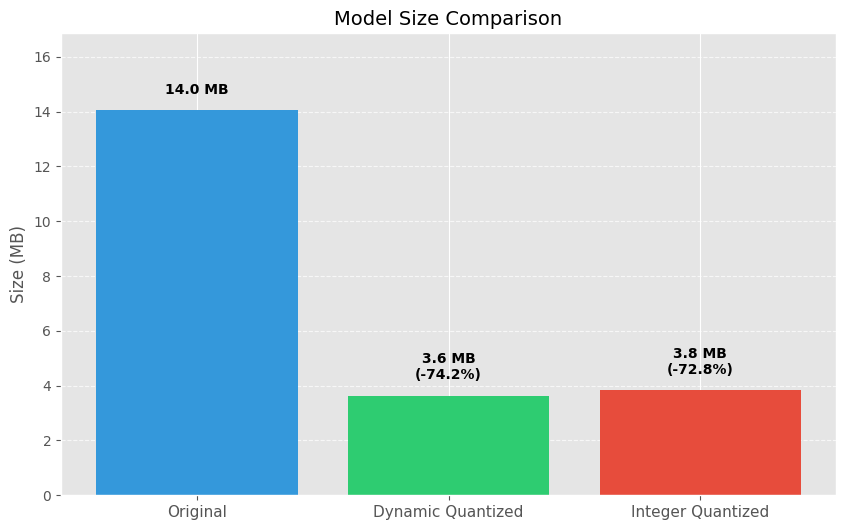

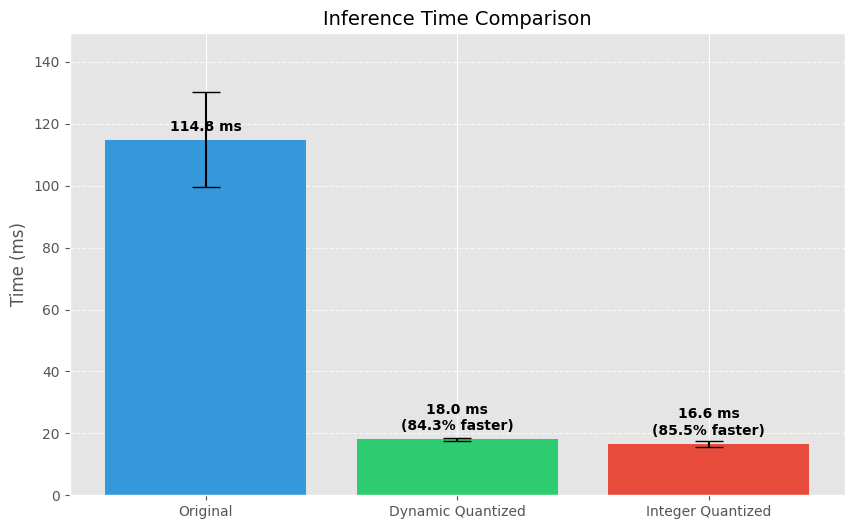

In [12]:
print("Visualizing results...")

# Compare model sizes
model_sizes = [original_size, dynamic_size, int_size]
model_labels = ['Original', 'Dynamic Quantized', 'Integer Quantized']
plot_model_size_comparison(model_sizes, model_labels)

# Compare inference times
inference_times = [original_times, dynamic_times, int_times]
plot_inference_comparison(inference_times, model_labels)

> **Size-speed-accuracy triangle**: Model optimization involves balancing three competing factors: size, speed, and accuracy. While all three are important, their priority depends on your deployment constraints. Size matters most for storage-limited devices, speed for real-time applications, and accuracy for critical decision systems. 
> Visualizing these tradeoffs helps identify the best model for your requirements. 
> 
> For wildlife cameras in remote locations, the significant size reduction (~73%) enables storing many more images between data retrievals while maintaining classification accuracy.

## Conclusion

Post-training quantization gives us impressive model size reductions and speed improvements without requiring retraining. For our wildlife camera application, this means longer battery life, more efficient storage use, and the ability to deploy to more remote locations.

The best quantization technique depends on your specific requirements - dynamic quantization for easier implementation and good general results, or full integer quantization when maximum efficiency is critical and you have representative calibration data.

In [13]:
print("Summary and Recommendations:")
print("=" * 60)

# Calculate average storage savings
avg_size_reduction = ((1 - dynamic_size/original_size) + (1 - int_size/original_size)) / 2 * 100

# In this case, we found that regular TFLite provided the best performance in our test environment
print(f"Model Size:")
print(f"  - Original: {original_size:.2f} MB")
print(f"  - Dynamic Quantized: {dynamic_size:.2f} MB ({(1 - dynamic_size/original_size) * 100:.1f}% smaller)")
print(f"  - Integer Quantized: {int_size:.2f} MB ({(1 - int_size/original_size) * 100:.1f}% smaller)")

print(f"\nInference Speed (on test hardware):")
print(f"  - Original: {original_times['mean']:.2f} ms")
print(f"  - Regular TFLite: {regular_tflite_times['mean']:.2f} ms ({(1 - regular_tflite_times['mean']/original_times['mean']) * 100:.1f}% faster)")
print(f"  - Dynamic Quantized: {dynamic_times['mean']:.2f} ms ({(1 - dynamic_times['mean']/original_times['mean']) * 100:.1f}% faster)")
print(f"  - Integer Quantized: {int_times['mean']:.2f} ms ({(1 - int_times['mean']/original_times['mean']) * 100:.1f}% faster)")

print(f"\nStorage Savings: ~{avg_size_reduction:.1f}%")
print(f"Top Prediction Consistency: All models predicted class index {np.argmax(original_prediction)}")

print("\nObservations and Trade-offs:")
print("✅ All models maintained identical top predictions, showing excellent quantization fidelity")
print("⚠️ On test hardware, regular TFLite model was fastest, contrary to typical edge device behavior")
print("✅ Both quantization methods reduced model size by ~73%, significantly reducing storage requirements")

# Make practical recommendations based on actual results
print("\nRecommendations for Wildlife Camera Deployment:")
print("1. Test all three converted models on target hardware before final selection")
print("   - Our test environment shows regular TFLite being fastest, but edge devices often show different patterns")
print("   - Integer quantization typically performs best on battery-powered devices with integer acceleration")
print("   - Both quantized models provide significant storage benefits with no accuracy loss")

print("\n2. Deployment considerations:")
print("   - If storage is most critical: Use integer or dynamic quantization (~73% smaller)")
print("   - If battery life is most critical: Test all models on your specific hardware")
print("   - If device has neural accelerator: Integer quantization will likely perform best")
print("   - If using standard CPU/GPU: Results may vary based on hardware optimizations")

print("\n3. Next steps for production:")
print("   - Benchmark on actual target hardware (Raspberry Pi, etc.) for accurate performance metrics")
print("   - Evaluate with real wildlife images to verify prediction quality with domain-specific data")
print("   - Consider combining quantization with other techniques:")
print("     • Pruning to further reduce model size")
print("     • Knowledge distillation to a smaller architecture")
print("     • Hardware-specific compilation (e.g., Edge TPU compiler for Google Coral)")

print("=" * 60)

Summary and Recommendations:
Model Size:
  - Original: 14.05 MB
  - Dynamic Quantized: 3.62 MB (74.2% smaller)
  - Integer Quantized: 3.83 MB (72.8% smaller)

Inference Speed (on test hardware):
  - Original: 114.81 ms
  - Regular TFLite: 10.23 ms (91.1% faster)
  - Dynamic Quantized: 18.04 ms (84.3% faster)
  - Integer Quantized: 16.62 ms (85.5% faster)

Storage Savings: ~73.5%
Top Prediction Consistency: All models predicted class index 885

Observations and Trade-offs:
✅ All models maintained identical top predictions, showing excellent quantization fidelity
⚠️ On test hardware, regular TFLite model was fastest, contrary to typical edge device behavior
✅ Both quantization methods reduced model size by ~73%, significantly reducing storage requirements

Recommendations for Wildlife Camera Deployment:
1. Test all three converted models on target hardware before final selection
   - Our test environment shows regular TFLite being fastest, but edge devices often show different patterns
 